In [2]:
import torch
from torchvision import datasets, transforms
import torch.autograd
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import random
import time
import matplotlib.pyplot as plt


class Fu(nn.Module):
    def __init__(self,size_x,size_y,k):
        nn.Module.__init__(self)
        self.linear = nn.ModuleList([nn.Linear(size_x, size_y) for _ in range(k)])

    def forward(self, x, h):
        return F.tanh(self.linear[h].forward(x))


class G(nn.Module):
    def __init__(self, size_x, k):
        nn.Module.__init__(self)
        self.m = nn.Linear(size_x, k)

    def forward(self, x):
        return torch.log(F.softmax(self.m.forward(x)))



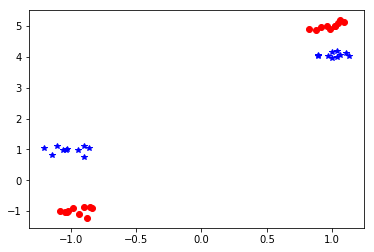

In [4]:
def generateXor_dataset(nb_sample):
    data = np.zeros((nb_sample,3))
    for i in range(int(nb_sample/4)):
        data[i][1] = (np.random.normal(1,0.1))
        data[i][2] = (np.random.normal(5,0.1))
        data[i][0] = int(1)

    for i in range(int(nb_sample/4),int(0.5*nb_sample)):
        data[i][1] = (np.random.normal(1,0.1))
        data[i][2] = (np.random.normal(4,0.1))
        data[i][0] = int(-1)

    for i in range(int(0.5*nb_sample) ,int(0.75*nb_sample)):
        data[i][1] = (np.random.normal(-1, 0.1))
        data[i][2] = (np.random.normal(1, 0.1))
        data[i][0] = int(-1)

    for i in range(int(0.75*nb_sample),int(nb_sample)):
        data[i][1] = (np.random.normal(-1,0.1))
        data[i][2] = (np.random.normal(-1,0.1))
        data[i][0] = int(1)

    data= torch.from_numpy(data)
    return data

def plot_data(data, labels):
    data = data.numpy()
    labels = labels.numpy()
    pos = np.where(labels == 1)[0]
    neg = np.where(labels == -1)[0]

    data = np.array(data.tolist())
    plt.plot(data[pos, 0], data[pos, 1], 'ro')
    plt.plot(data[neg, 0], data[neg, 1], 'b*')


test = generateXor_dataset(40)
plot_data(test[:,1:3],test[:,0])
plt.show()

In [ ]:
#data
generate = generateXor_dataset(100)
data = generate[:,1:3]
label = generate[:,0]

#taille de l'espace pour le tirage
H=2

g = G(2,2)
f = Fu(2,2,2)
l = nn.MSELoss()

optimizer1 = torch.optim.Adam(f.parameters(),lr=0.05)
optimizer2 = torch.optim.Adam(g.parameters(),lr=0.05)
loss_array = []

nb_iter = 300

for it in range(nb_iter):
    optimizer1.zero_grad()
    optimizer2.zero_grad()
    to_print = 0
    for i in range(len(data)):

        x = data[i,:]
        x = x.type(torch.FloatTensor)
        x = Variable(x)
        logP = g.forward(x)
        h = logP.exp().multinomial()

        y = torch.zeros(2)
        y[int((label[i]+1)/2)] = 1.

        out = f.forward(x,h.data[0])

        loss = l.forward(out, Variable(y))

        loss.backward()

        (logP[h.data]*Variable(loss.data)).backward()
        to_print += (logP[0] * logP[0].exp() + logP[1] * logP[1].exp()).data[0]
    loss_array.append(-to_print)
    optimizer1.step()
    optimizer2.step()


plt.plot(loss_array)
plt.show()

In [6]:
##ACCURACY
accuracy = 0
for i in range(len(data)):
    x = data[i, :]
    x = x.type(torch.FloatTensor)
    x = Variable(x)
    logP = g.forward(x)
    h = logP.exp().multinomial()

    out = f.forward(x, h.data[0])

    y = (label[i]+1)/2
    accuracy += 1*(torch.max(out,0)[1].data[0]==y)
    #print(accuracy)
print(accuracy / len(data))

1.0


In [7]:
#Tracons la frontière pour le tirage
#tous les parametres = poids + biais
weight_frontiere = list(g.parameters())[0]
bias_frontiere = list(g.parameters())[1]

#l'équation 
print(str((weight_frontiere[0,0]-weight_frontiere[1,0]).data[0])+'*X + ' 
      + str((weight_frontiere[0,1]-weight_frontiere[1,1]).data[0])+'*Y + ' 
      + str((bias_frontiere[0]-bias_frontiere[1]).data[0]) + '=0')

3.8519773483276367*X + 2.3634684085845947*Y + -1.464447259902954=0


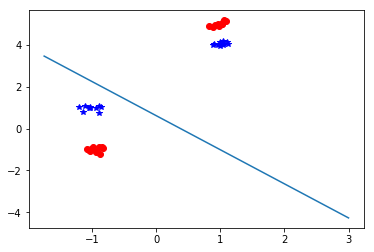

In [11]:
def frontiere(x):
    return((bias_frontiere[1]-bias_frontiere[0]).data[0]/(weight_frontiere[0,1]-weight_frontiere[1,1]).data[0] + (weight_frontiere[1,0]-weight_frontiere[0,0]).data[0]/(weight_frontiere[0,1]-weight_frontiere[1,1]).data[0]*x)
frontiere = np.vectorize(frontiere)

plot_data(test[:,1:3],test[:,0])
plt.plot([i/4 for i in range(-7,13,1)],frontiere([i/4 for i in range(-7,13,1)]))

plt.show()

In [12]:
weight_mod1 = list(f.linear[0].parameters())[0]
bias_mod1 = list(f.linear[0].parameters())[1]

#l'équation 
print(str((weight_mod1[0,0]-weight_mod1[1,0]).data[0])+'*X + ' 
      + str((weight_mod1[0,1]-weight_mod1[1,1]).data[0])+'*Y + ' 
      + str((bias_mod1[0]-bias_mod1[1]).data[0]) + '=0')

def frontiere_mod1(x):
    return((bias_mod1[1]-bias_mod1[0]).data[0]/(weight_mod1[0,1]-weight_mod1[1,1]).data[0] + (weight_mod1[1,0]-weight_mod1[0,0]).data[0]/(weight_mod1[0,1]-weight_mod1[1,1]).data[0]*x)
frontiere_mod1 = np.vectorize(frontiere_mod1)

weight_mod2 = list(f.linear[1].parameters())[0]
bias_mod2 = list(f.linear[1].parameters())[1]

#l'équation 
print(str((weight_mod2[0,0]-weight_mod2[1,0]).data[0])+'*X + ' 
      + str((weight_mod2[0,1]-weight_mod2[1,1]).data[0])+'*Y + ' 
      + str((bias_mod2[0]-bias_mod2[1]).data[0]) + '=0')

def frontiere_mod2(x):
    return((bias_mod2[1]-bias_mod2[0]).data[0]/(weight_mod2[0,1]-weight_mod2[1,1]).data[0] + (weight_mod2[1,0]-weight_mod2[0,0]).data[0]/(weight_mod2[0,1]-weight_mod2[1,1]).data[0]*x)
frontiere_mod2 = np.vectorize(frontiere_mod2)


2.2345685958862305*X + -1.994931936264038*Y + 6.6976213455200195=0
0.15516254305839539*X + 1.9190865755081177*Y + 0.13995051383972168=0


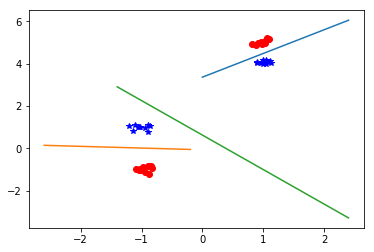

In [17]:
plot_data(test[:,1:3],test[:,0])
plt.plot([i/5 for i in range(0,13,1)],frontiere_mod1([i/5 for i in range(0,13,1)]))
plt.plot([i/5 for i in range(-13,0,1)],frontiere_mod2([i/5 for i in range(-13,0,1)]))
plt.plot([i/5 for i in range(-7,13,1)],frontiere([i/5 for i in range(-7,13,1)]))

plt.show()